In [3]:
#nathan's 3060ish card
!nvidia-smi

Sat Feb 28 23:17:16 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


|   0  NVIDIA Graphics Device         Off |   00000000:01:00.0 Off |                  N/A |
|  0%   38C    P8              7W /  170W |       4MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|  No running processes found                                                     

In [54]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.modules.conv import Conv2d

import pandas as pd

import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
SEED=42
torch.manual_seed(SEED)
BATCH_SIZE=32

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
# personally i use l(learn) as training data and t(test) as testing data
l_data=FashionMNIST(
    root="data", #download loc
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

t_data=FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [11]:
len(l_data), len(t_data)

(60000, 10000)

In [12]:
img,tag=l_data[0]
#channle * hight * width, tag is the label of the image
img.shape, tag

(torch.Size([1, 28, 28]), 9)

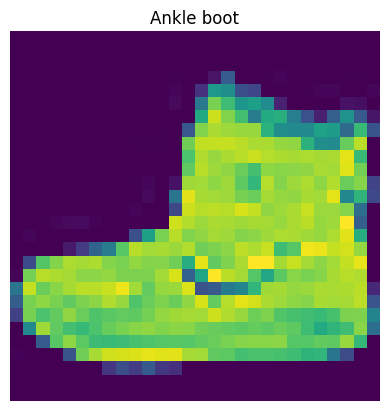

In [16]:
plt.imshow(img.squeeze());
plt.title(l_data.classes[tag]);
plt.axis(False);

In [18]:
len(l_data.classes)

10

In [21]:
l_dl=DataLoader(l_data, batch_size=BATCH_SIZE, shuffle=True)
t_dl=DataLoader(t_data, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
class CNN(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, hidden_units:int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2=nn.Sequential(
            Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,out_features=out_channels) # 7 is the img len after 2 MaxPool2d (28/2/2)
        )
    def forward(self,x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x

In [38]:
model=CNN(in_channels=1, out_channels=len(l_data.classes), hidden_units=10).to(device)
model

CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [44]:
def train_loop(model:nn.Module, train_dataloader:DataLoader, test_dataloader:DataLoader, optimizer, loss_fn, epochs:int, device):
    '''Train and test a PyTorch model.'''
    loss_fn=loss_fn.to(device)
    for epoch in range(epochs):

        # batch training
        model.train()
        l_loss=0
        for batch, (X,y) in enumerate(train_dataloader):
            X,y=X.to(device),y.to(device)
            # forward pass + compute the loss
            loss=loss_fn(model(X),y)
            l_loss+=loss#.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
        l_loss/=len(train_dataloader)
        
        # batch testing
        model.eval()
        t_loss=0
        with torch.inference_mode():
            for batch, (X,y) in enumerate(test_dataloader):
                X,y=X.to(device),y.to(device)
                t_loss+=loss_fn(model(X),y).item()
        t_loss/=len(test_dataloader)
        # compute accuracy
        t_acc=0
        with torch.inference_mode():
            for batch, (X,y) in enumerate(test_dataloader):
                X,y=X.to(device),y.to(device)
                t_acc+=(model(X).argmax(dim=1)==y).sum().item()
        t_acc/=len(test_dataloader.dataset)
        print(f"Epoch: {epoch} | Train loss: {l_loss} | Test loss: {t_loss} | Test accuracy: {t_acc}")

In [45]:
train_loop(model=model,
           train_dataloader=l_dl,
           test_dataloader=t_dl,
           optimizer=torch.optim.SGD(model.parameters(), lr=0.1),
           loss_fn=nn.CrossEntropyLoss(),
           epochs=16,
           device=device)

Epoch: 0 | Train loss: 0.22578397393226624 | Test loss: 0.2842026774774487 | Test accuracy: 0.8995
Epoch: 1 | Train loss: 0.22395503520965576 | Test loss: 0.26318588388708836 | Test accuracy: 0.9039
Epoch: 2 | Train loss: 0.220039963722229 | Test loss: 0.27144675026424586 | Test accuracy: 0.9023
Epoch: 3 | Train loss: 0.21977247297763824 | Test loss: 0.28325701381463686 | Test accuracy: 0.9033
Epoch: 4 | Train loss: 0.22054316103458405 | Test loss: 0.3017116089146168 | Test accuracy: 0.8967
Epoch: 5 | Train loss: 0.21814201772212982 | Test loss: 0.2987205529758058 | Test accuracy: 0.8926
Epoch: 6 | Train loss: 0.21613673865795135 | Test loss: 0.27377579267175434 | Test accuracy: 0.9049
Epoch: 7 | Train loss: 0.2158939242362976 | Test loss: 0.2908238065354645 | Test accuracy: 0.8987
Epoch: 8 | Train loss: 0.21252381801605225 | Test loss: 0.2800458294693559 | Test accuracy: 0.8997
Epoch: 9 | Train loss: 0.21533319354057312 | Test loss: 0.2918509410355038 | Test accuracy: 0.8962
Epoch: 10

In [47]:
model=CNN(in_channels=1, out_channels=len(l_data.classes), hidden_units=10).to(device)
train_loop(model=model,
           train_dataloader=l_dl,
           test_dataloader=t_dl,
           optimizer=torch.optim.SGD(model.parameters(), lr=0.05),
           loss_fn=nn.CrossEntropyLoss(),
           epochs=32,
           device=device)

Epoch: 0 | Train loss: 0.6544395089149475 | Test loss: 0.43300019723538774 | Test accuracy: 0.8447
Epoch: 1 | Train loss: 0.37270039319992065 | Test loss: 0.36747361743412077 | Test accuracy: 0.8724
Epoch: 2 | Train loss: 0.327541321516037 | Test loss: 0.32617871337138804 | Test accuracy: 0.8869
Epoch: 3 | Train loss: 0.30271852016448975 | Test loss: 0.31415690835148763 | Test accuracy: 0.8891
Epoch: 4 | Train loss: 0.2852800786495209 | Test loss: 0.30009427064428695 | Test accuracy: 0.8917
Epoch: 5 | Train loss: 0.27277448773384094 | Test loss: 0.30022432436101354 | Test accuracy: 0.8929
Epoch: 6 | Train loss: 0.2626233994960785 | Test loss: 0.2832644230094009 | Test accuracy: 0.8991
Epoch: 7 | Train loss: 0.2543064057826996 | Test loss: 0.2781496529404919 | Test accuracy: 0.9003
Epoch: 8 | Train loss: 0.24582931399345398 | Test loss: 0.27698616734661236 | Test accuracy: 0.9004
Epoch: 9 | Train loss: 0.24053286015987396 | Test loss: 0.27386636153077737 | Test accuracy: 0.9022
Epoch: 1

In [59]:
model.eval()
preds=[]
with torch.inference_mode():
    for batch, (X,y) in enumerate(t_dl):
        X,y=X.to(device),y.to(device)
        preds.append(model(X).argmax(dim=1))
preds=torch.cat(preds)
preds

tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0')

In [62]:
cm=ConfusionMatrix(task='multiclass',num_classes=len(l_data.classes))
cm_tensor=cm(preds=preds.cpu(),
                       target=t_data.targets)
cm_tensor

tensor([[844,   0,  15,  19,   8,   1, 107,   0,   6,   0],
        [  2, 976,   0,  19,   0,   0,   2,   0,   1,   0],
        [ 21,   1, 848,   9,  68,   0,  53,   0,   0,   0],
        [ 10,   1,  13, 914,  26,   0,  34,   0,   2,   0],
        [  2,   0,  44,  25, 898,   0,  31,   0,   0,   0],
        [  0,   0,   0,   0,   0, 984,   0,  11,   0,   5],
        [ 91,   1,  58,  26,  93,   0, 724,   0,   7,   0],
        [  0,   0,   0,   0,   0,  12,   0, 968,   0,  20],
        [  3,   0,   2,   2,   5,   1,   6,   5, 976,   0],
        [  0,   0,   0,   0,   0,   8,   0,  26,   0, 966]])

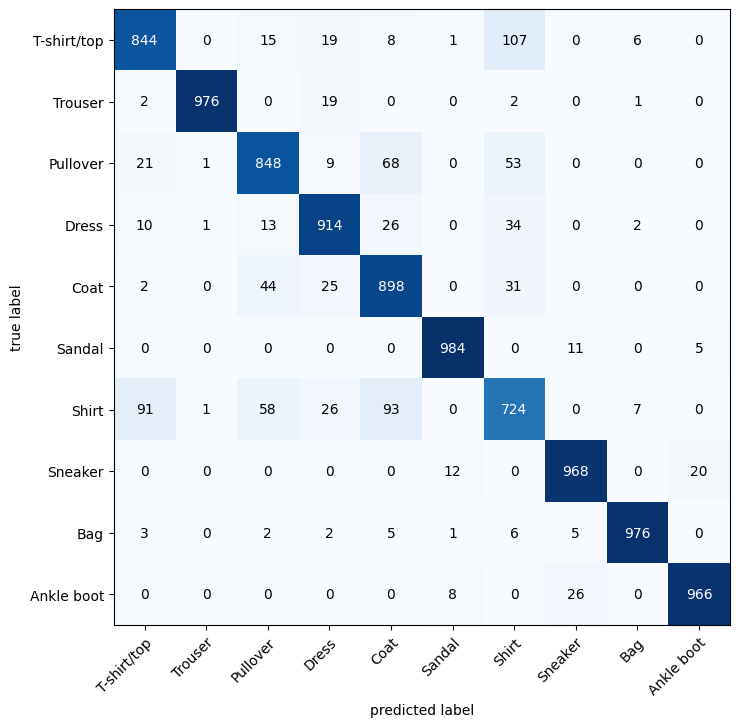

In [63]:
fig,ax=plot_confusion_matrix(
    conf_mat=cm_tensor.numpy(),
    class_names=l_data.classes,
    figsize=(8,8)
)